In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import optuna
import optunahub

def transform_features(df):
    if "NumOfConfUsed" in df.columns:
        df['NumOfConfUsed_log'] = np.log1p(df['NumOfConfUsed'])
        df['NumOfConfUsed_binned'] = pd.cut(df['NumOfConfUsed'], bins=[0, 10, 20, 30, 40], labels=[1, 2, 3, 4])
        df.drop(columns=['NumOfConfUsed'], inplace=True)
    
    if 'NumOfConfUsed_binned' in df.columns:
        df['NumOfConfUsed_binned'] = df['NumOfConfUsed_binned'].astype(int)  # Convert categories to integers
    
    if 'NumOfConf' in df.columns:
        df['NumOfConf_log'] = np.log1p(df['NumOfConf'])
        df.drop(columns=['NumOfConf'], inplace=True)
    
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df['ConfUsed_to_Atoms'] = df['NumOfConfUsed_log'] / (df['NumOfAtoms'] + 1e-5)  # Avoid division by zero
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    df['Conf_to_ConfUsed_ratio'] = df['NumOfConf_log'] / df['NumOfConfUsed_binned']
    df['MW_to_NumOfAtoms'] = df['MW'] / df['NumOfAtoms_sqrt']
    df['Experimental11'] = df['NumHBondDonors'] / df['NumOfConf_log'] # addition to best2
    df['Inter1'] = df['NumHBondDonors'] * df['MW']
    return df



def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 50.0),
        'random_state': 4,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**param, verbose=-1)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=7)
    scores = cross_val_score(model, train_transformed, target, cv=kf, scoring='neg_mean_squared_error')
    return -scores.mean()

# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features(train.copy())
test_transformed = transform_features(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)

# Separate the parentspecies columns
parentspecies_train = train_transformed.filter(like='parentspecies')
parentspecies_test = test_transformed.filter(like='parentspecies')

# Drop the parentspecies columns from the transformed data
train_transformed = train_transformed.drop(columns=parentspecies_train.columns)
test_transformed = test_transformed.drop(columns=parentspecies_test.columns)

# Save the column names before scaling
train_columns = train_transformed.columns
test_columns = test_transformed.columns

# Scale numerical features
scaler = StandardScaler()
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)

# Convert scaled numerical features back to DataFrame
train_transformed = pd.DataFrame(train_transformed, columns=train_columns)
test_transformed = pd.DataFrame(test_transformed, columns=test_columns)

# Add the parentspecies columns back to the scaled numerical features
train_transformed = pd.concat([train_transformed, parentspecies_train.reset_index(drop=True)], axis=1)
test_transformed = pd.concat([test_transformed, parentspecies_test.reset_index(drop=True)], axis=1)


# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize', study_name='lgbm_optuna_study_for_transformations_v2',
                            storage="sqlite:///../Data/optuna2.db", load_if_exists=True)
study.optimize(objective, n_trials=250)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)

# Evaluate the model
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)

# Save predictions to a CSV file
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("optuna_lgbm_predictions_scaled.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()


[I 2024-12-06 00:26:16,666] A new study created in RDB with name: lgbm_optuna_study_for_transformations_v2
[I 2024-12-06 00:26:59,205] Trial 0 finished with value: 3.0834153519288394 and parameters: {'n_estimators': 1211, 'learning_rate': 0.45472332826491835, 'num_leaves': 71, 'max_depth': 8, 'min_child_samples': 148, 'subsample': 0.9331824139295952, 'colsample_bytree': 0.8681755236637564, 'reg_alpha': 0.38050942586861747, 'reg_lambda': 0.4071996009718637, 'cat_smooth': 19.79510761355119}. Best is trial 0 with value: 3.0834153519288394.
[I 2024-12-06 00:27:22,137] Trial 1 finished with value: 2.6609580063091505 and parameters: {'n_estimators': 1975, 'learning_rate': 0.3910211485098716, 'num_leaves': 65, 'max_depth': 1, 'min_child_samples': 50, 'subsample': 0.5650948680923678, 'colsample_bytree': 0.6367753050905106, 'reg_alpha': 0.38469861265168814, 'reg_lambda': 0.7378695781406877, 'cat_smooth': 43.25084382293712}. Best is trial 1 with value: 2.6609580063091505.
[I 2024-12-06 00:27:51,

In [24]:
def transform_features2(df):
    """
    Apply transformations to the input DataFrame based on observed distributions.
    """
    # Log transformation for MW
    if 'MW' in df.columns:
        df['MW_log'] = np.log1p(df['MW'])  # log(1+x) to avoid log(0)
        df.drop(columns=['MW'], inplace=True)
    
    if "NumOfConfUsed" in df.columns:
        df['NumOfConfUsed_log'] = np.log1p(df['NumOfConfUsed'])
        df['NumOfConfUsed_binned'] = pd.cut(df['NumOfConfUsed'], bins=[0, 10, 20, 30, 40], labels=[1, 2, 3, 4])
        df.drop(columns=['NumOfConfUsed'], inplace=True)
    
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df['ConfUsed_to_Atoms'] = df['NumOfConfUsed_log'] / (df['NumOfAtoms'] + 1e-5)  # Avoid division by zero
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    #Bin NumOfN into categories
    #if 'NumOfN' in df.columns:
    #    bins = [-1, 0, 1, 2]  # Define bin edges
    #    labels = ['0', '1', '2']
    #    df['NumOfN_binned'] = pd.cut(df['NumOfN'], bins=bins, labels=labels, include_lowest=True)
    #    df.drop(columns=['NumOfN'], inplace=True)
    
    if 'NumOfN_binned' in df.columns:
        df['NumOfN_binned'] = df['NumOfN_binned'].astype(int)  # Convert categories to integers

    if 'NumOfConfUsed_binned' in df.columns:
        df['NumOfConfUsed_binned'] = df['NumOfConfUsed_binned'].astype(int)  # Convert categories to integers
        
    df['Conf_to_ConfUsed_ratio'] = df['NumOfConf'] / df['NumOfConfUsed_binned']
    df['MW_to_NumOfAtoms'] = df['MW_log'] / df['NumOfAtoms_sqrt']
    df['Experimental11'] = df['NumHBondDonors'] / df['NumOfConf'] # addition to best2
    #df['Inter1'] = df['NumHBondDonors'] * df['MW_log']
    return df


def objective2(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 50.0),
        'random_state': 4,
        'n_jobs': -1
    }
    
    
    model = lgb.LGBMRegressor(**param, verbose=-1)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=4)
    scores = cross_val_score(model, train_transformed, target, cv=kf, scoring='neg_mean_absolute_error')
    return -scores.mean()


In [17]:
def objective3(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'cat_smooth': trial.suggest_float('cat_smooth', 1.0, 100.0),
        'max_bin': trial.suggest_int('max_bin', 100, 500),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'random_state': 4,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**param, verbose=-1)
    
    kf = KFold(n_splits=10, shuffle=True, random_state=4)
    scores = cross_val_score(model, train_transformed, target, cv=kf, scoring='neg_mean_absolute_error')
    return -scores.mean()

In [18]:
# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features2(train.copy())
test_transformed = transform_features2(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)

# Separate the parentspecies columns
parentspecies_train = train_transformed.filter(like='parentspecies')
parentspecies_test = test_transformed.filter(like='parentspecies')

# Drop the parentspecies columns from the transformed data
train_transformed = train_transformed.drop(columns=parentspecies_train.columns)
test_transformed = test_transformed.drop(columns=parentspecies_test.columns)

# Save the column names before scaling
train_columns = train_transformed.columns
test_columns = test_transformed.columns

# Scale numerical features
scaler = StandardScaler()
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)

# Convert scaled numerical features back to DataFrame
train_transformed = pd.DataFrame(train_transformed, columns=train_columns)
test_transformed = pd.DataFrame(test_transformed, columns=test_columns)

# Add the parentspecies columns back to the scaled numerical features
train_transformed = pd.concat([train_transformed, parentspecies_train.reset_index(drop=True)], axis=1)
test_transformed = pd.concat([test_transformed, parentspecies_test.reset_index(drop=True)], axis=1)

# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective3, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
best_params = study.best_params

#best_params = {'n_estimators': 612, 'learning_rate': 0.03253420017567533, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7456333280664998, 'colsample_bytree': 0.9137393037318097, 'reg_alpha': 0.7026860907781649, 'reg_lambda': 0.7187304208680759}

model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)

# Evaluate the model
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)

# Save predictions to a CSV file
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("lgbm_best_reopt2.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")

[I 2024-12-05 19:34:15,694] A new study created in memory with name: no-name-e40bd4b6-3ce2-49a3-b21d-fef26c9d88ab
[I 2024-12-05 19:34:26,035] Trial 0 finished with value: 1.1897552159144977 and parameters: {'n_estimators': 749, 'learning_rate': 0.29888079977633175, 'num_leaves': 145, 'max_depth': 14, 'min_child_samples': 12, 'min_split_gain': 0.3298648422874739, 'min_child_weight': 0.36823336233443793, 'subsample': 0.8577408639094919, 'colsample_bytree': 0.4194461479429425, 'reg_alpha': 9.97571941834791, 'reg_lambda': 8.882450186052088, 'cat_smooth': 34.25104458959321, 'max_bin': 488, 'bagging_fraction': 0.9499913754529863, 'bagging_freq': 6}. Best is trial 0 with value: 1.1897552159144977.
[I 2024-12-05 19:34:35,690] Trial 1 finished with value: 1.16640762388009 and parameters: {'n_estimators': 702, 'learning_rate': 0.19252187027420273, 'num_leaves': 79, 'max_depth': 20, 'min_child_samples': 33, 'min_split_gain': 0.6256081588188572, 'min_child_weight': 5.209806205111611, 'subsample': 

KeyboardInterrupt: 

### current best kaggle 0.7551 hps
Best hyperparameters:  {'n_estimators': 612, 'learning_rate': 0.03253420017567533, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7456333280664998, 'colsample_bytree': 0.9137393037318097, 'reg_alpha': 0.7026860907781649, 'reg_lambda': 0.7187304208680759}



run 7 feat plot
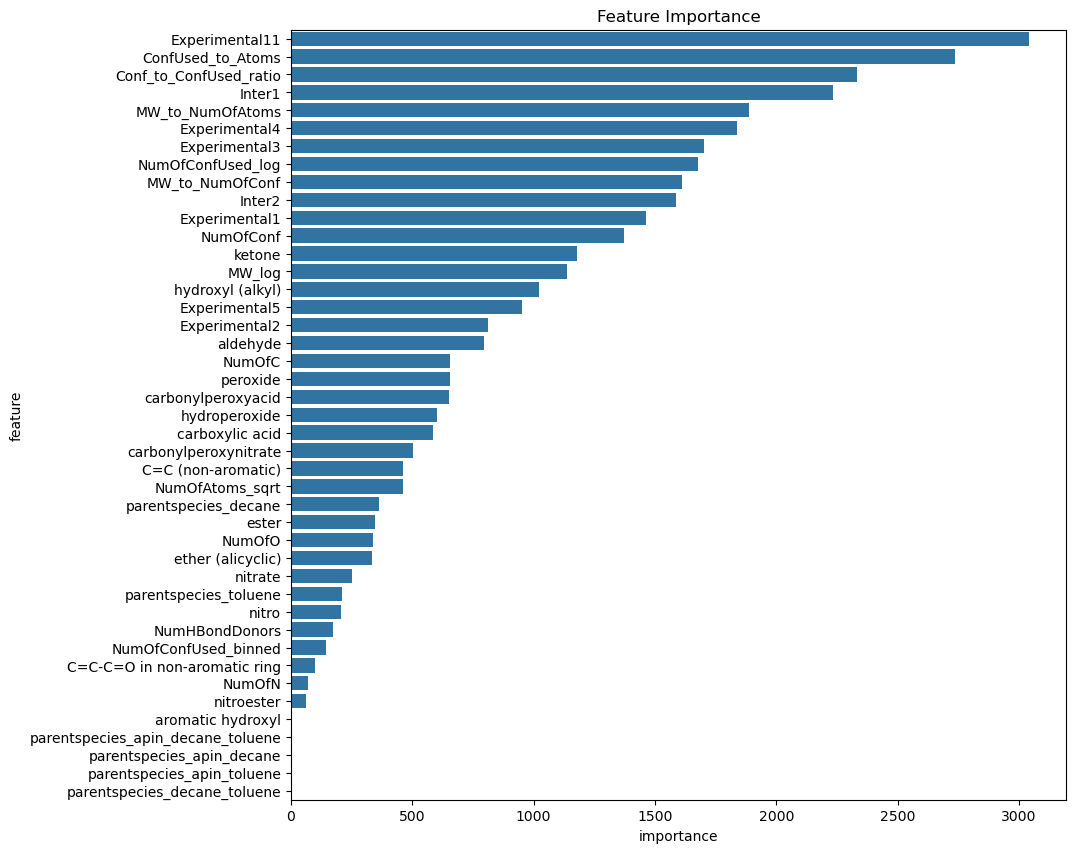

                              feature  importance
24                  ConfUsed_to_Atoms        8952
26             Conf_to_ConfUsed_ratio        7387
27                   MW_to_NumOfAtoms        6656
3                           NumOfConf        6455
28                    MW_to_NumOfConf        5949
20                             MW_log        5415
21                  NumOfConfUsed_log        4849
0                              NumOfC        2769
1                              NumOfO        2597
6                    hydroxyl (alkyl)        2546
8                              ketone        2353
2                      NumHBondDonors        2197
23                    NumOfAtoms_sqrt        2083
7                            aldehyde        1761
17                      hydroperoxide        1521
18                 carbonylperoxyacid        1513
9                     carboxylic acid        1374
16                           peroxide        1078
15              carbonylperoxynitrate        1059


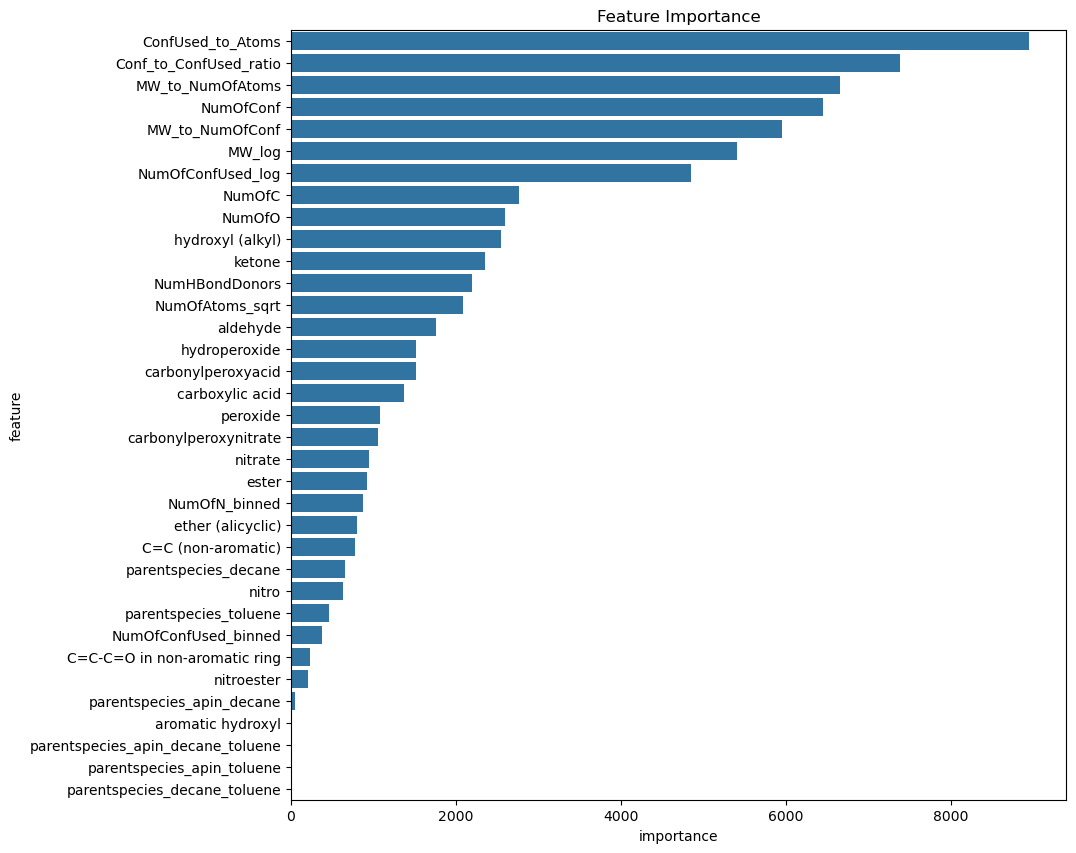

In [ ]:
# placeholder for viewwing the feature importance

In [22]:

best_params = study.best_params
model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)

# Evaluate the model
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)

# Save predictions to a CSV file
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("optuna_testing_partNNNN.csv", index=False)

RMSE: 1.4090
MAE: 1.0322
R^2: 0.7961


/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features2(train.copy())
test_transformed = transform_features2(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)


RMSE: 1.3394
MAE: 0.9874
R^2: 0.8157
                              feature  importance
24                  ConfUsed_to_Atoms        2730
27                     Experimental11        2693
25             Conf_to_ConfUsed_ratio        2566
26                   MW_to_NumOfAtoms        2391
28                             Inter1        2042
29                             Inter2        1663
4                           NumOfConf        1657
21                             MW_log        1639
0                              NumOfC        1570
22                  NumOfConfUsed_log        1502
9                              ketone        1068
7                    hydroxyl (alkyl)         989
8                            aldehyde         869
1                              NumOfO         802
10                    carboxylic acid         696
16              carbonylperoxynitrate         635
17                           peroxide         631
19                 carbonylperoxyacid         609
18           

/home/saavajuu/anaconda3/envs/iml_env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Feature Importance')

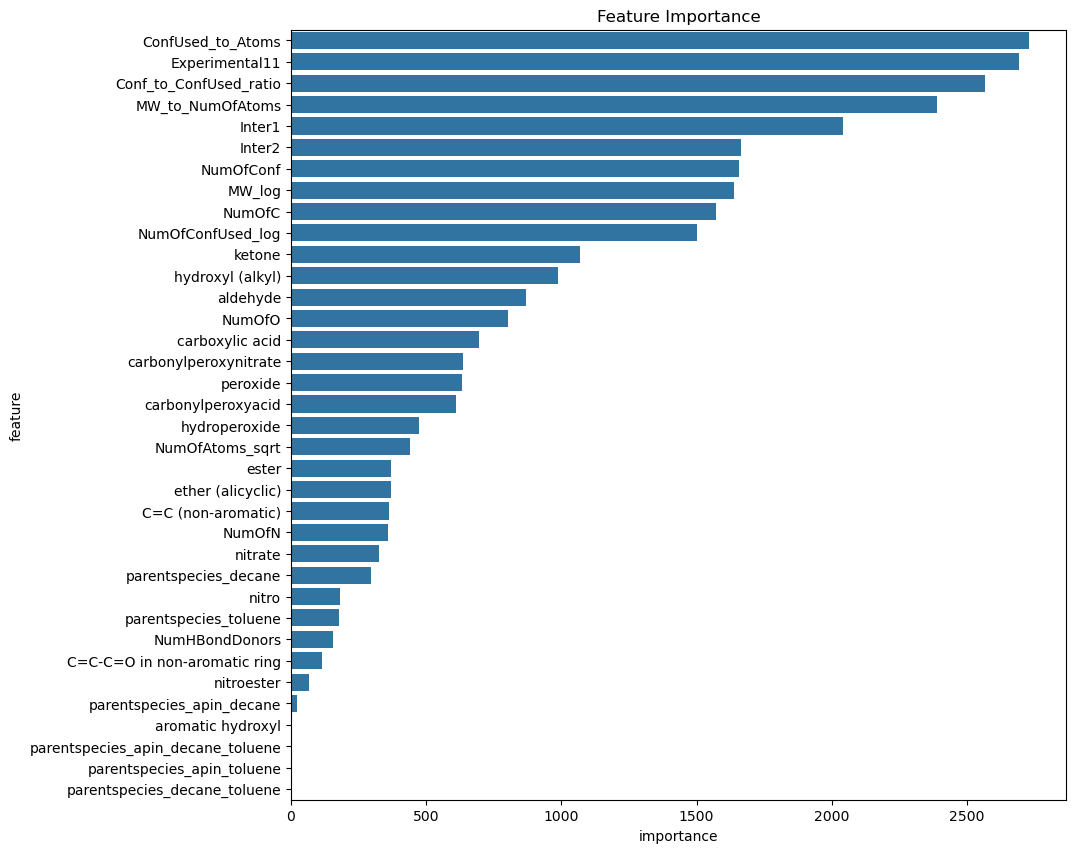

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

def transform_features2(df):
    if 'MW' in df.columns:
        df['MW_log'] = np.log1p(df['MW'])  # log(1+x) to avoid log(0)
        df.drop(columns=['MW'], inplace=True)
    
    if "NumOfConfUsed" in df.columns:
        df['NumOfConfUsed_log'] = np.log1p(df['NumOfConfUsed'])
        df.drop(columns=['NumOfConfUsed'], inplace=True)
    
    if 'NumOfAtoms' in df.columns:
        df['NumOfAtoms_sqrt'] = np.sqrt(df['NumOfAtoms'])
        df['ConfUsed_to_Atoms'] = df['NumOfConfUsed_log'] / (df['NumOfAtoms'] + 1e-5)  # Avoid division by zero
        df.drop(columns=['NumOfAtoms'], inplace=True)
    
    if 'NumOfN_binned' in df.columns:
        df['NumOfN_binned'] = df['NumOfN_binned'].astype(int)  # Convert categories to integers
    # Convert categories to integers
        
    df['Conf_to_ConfUsed_ratio'] = df['NumOfConf'] / df['NumOfConfUsed_log']
    df['MW_to_NumOfAtoms'] = df['MW_log'] / df['NumOfAtoms_sqrt']
    df['Experimental11'] = df['NumHBondDonors'] / df['NumOfConf'] # addition to best2

    return df

# Load data
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")

# Preserve the ID column
test_ids = test["ID"]

# Drop ID column from test data
test.drop(columns=["ID"], inplace=True)

# Separate target variable from training data
target = train["log_pSat_Pa"]
train.drop(columns=["log_pSat_Pa", "ID"], inplace=True)

# Apply feature engineering
train_transformed = transform_features2(train.copy())
test_transformed = transform_features2(test.copy())

# One-hot encode categorical features "parentspecies" column
train_transformed = pd.get_dummies(train_transformed, columns=["parentspecies"], drop_first=True)
test_transformed = pd.get_dummies(test_transformed, columns=["parentspecies"], drop_first=True)

# Align the columns of train and test data
train_transformed, test_transformed = train_transformed.align(test_transformed, join='left', axis=1, fill_value=0)

# Separate the parentspecies columns
parentspecies_train = train_transformed.filter(like='parentspecies')
parentspecies_test = test_transformed.filter(like='parentspecies')

# Drop the parentspecies columns from the transformed data
train_transformed = train_transformed.drop(columns=parentspecies_train.columns)
test_transformed = test_transformed.drop(columns=parentspecies_test.columns)

# Save the column names before scaling
train_columns = train_transformed.columns
test_columns = test_transformed.columns

# Scale numerical features
scaler = StandardScaler()
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)

# Convert scaled numerical features back to DataFrame
train_transformed = pd.DataFrame(train_transformed, columns=train_columns)
test_transformed = pd.DataFrame(test_transformed, columns=test_columns)

# Add the parentspecies columns back to the scaled numerical features
train_transformed = pd.concat([train_transformed, parentspecies_train.reset_index(drop=True)], axis=1)
test_transformed = pd.concat([test_transformed, parentspecies_test.reset_index(drop=True)], axis=1)

best_params = {'n_estimators': 612, 'learning_rate': 0.03253420017567533, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.7456333280664998, 'colsample_bytree': 0.9137393037318097, 'reg_alpha': 0.7026860907781649, 'reg_lambda': 0.7187304208680759}
model = lgb.LGBMRegressor(**best_params)
model.fit(train_transformed, target)

# Predict on the training set
train_predictions = model.predict(train_transformed)
rmse = mean_squared_error(target, train_predictions, squared=False)
mae = mean_absolute_error(target, train_predictions)
r2 = r2_score(target, train_predictions)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}")

# Predict on the test set
test_predictions = model.predict(test_transformed)
output = pd.DataFrame({"ID": test_ids, "TARGET": test_predictions})
output.to_csv("lgbm_best_cur2.csv", index=False)

# view the feature importance
importance = model.feature_importances_
feature_names = train_transformed.columns
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importance})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# plot the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")